In [1]:
import gzip
from collections import defaultdict
import math
import random
import numpy as np
import scipy.optimize

def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

#reading data
rawdata=list(readGz("reviews_Electronics_5.json.gz"))

In [2]:
import string
import pandas as pd
def pad(c): return ' '+c
remove_table = str.maketrans({}.fromkeys(string.punctuation))
keep_table = str.maketrans({pun:pad(pun) for pun in string.punctuation})
table={True: remove_table, False:keep_table}

#clean the data before fitting
def clean(text,table,remove):
    return text.lower().translate(table[remove])

data=rawdata
for d in data:
    d['reviewText']=clean(d['reviewText'],table,True)
data=data[:100000]
df=pd.DataFrame.from_dict(data)
df.drop(columns=['helpful','reviewTime','reviewerID','reviewerName',
                 'summary','unixReviewTime'],inplace=True)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

pipeline=Pipeline([
    ('vect', CountVectorizer()),
    ('clf', linear_model.Ridge()),
])

params={'clf__alpha':[0.1,1,10,100],
       'clf__fit_intercept':[True],
       'vect__max_features': [1000,2000,3000],
       'vect__stop_words':['english',None],
       'vect__ngram_range':[(1,1),(1,2),(1,3)]
       }
grid_search=GridSearchCV(pipeline, params,cv=3,verbose=1,
                         scoring='neg_mean_squared_error')
grid_search.fit(df.reviewText,df.overall)

In [219]:
grid_search.best_score_

-0.7969675004184951

In [9]:
grid_search.best_params_

{'clf__alpha': 1,
 'clf__fit_intercept': True,
 'vect__max_features': 3000,
 'vect__ngram_range': (1, 2),
 'vect__stop_words': None}

In [57]:
res=pd.DataFrame(grid_search.cv_results_)

/Users/keithzeng/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/keithzeng/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/keithzeng/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/keithzeng/an

In [214]:
res_n=res.fillna('None')
res_n.mean_train_score=-res_n.mean_train_score
res_n.mean_test_score=-res_n.mean_test_score

param_vect__stop_words  param_vect__max_features
None                    1000                        0.934736
                        2000                        0.860241
                        3000                        0.828705
english                 1000                        0.950964
                        2000                        0.887493
                        3000                        0.864557
Name: mean_test_score, dtype: float64

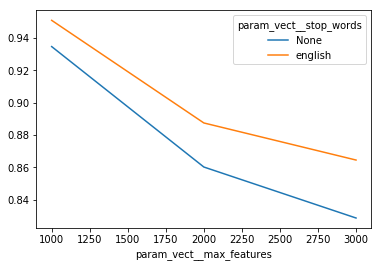

In [215]:
grouped=res_n.groupby(['param_vect__stop_words','param_vect__max_features']).mean()
grouped.unstack('param_vect__stop_words').plot(y='mean_test_score')
grouped['mean_test_score']

param_vect__stop_words  param_clf__alpha
None                    0.1                 0.856025
                        1.0                 0.855486
                        10.0                0.857381
                        100.0               0.929350
english                 0.1                 0.884180
                        1.0                 0.883666
                        10.0                0.884427
                        100.0               0.951745
Name: mean_test_score, dtype: float64

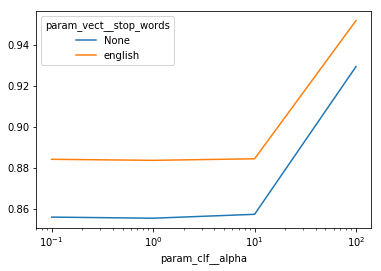

In [216]:
grouped=res_n.groupby(['param_vect__stop_words','param_clf__alpha']).mean()
grouped.unstack('param_vect__stop_words').plot(y='mean_test_score',logx=True)
grouped['mean_test_score']

param_vect__ngram_range  param_vect__max_features
(1, 1)                   1000                        0.940291
                         2000                        0.876344
                         3000                        0.856217
(1, 2)                   1000                        0.943774
                         2000                        0.871917
                         3000                        0.841580
(1, 3)                   1000                        0.944485
                         2000                        0.873340
                         3000                        0.842095
Name: mean_test_score, dtype: float64

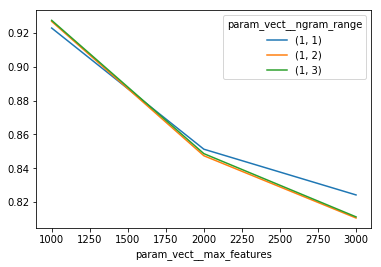

In [217]:
grouped=res_n.groupby(['param_vect__ngram_range','param_vect__max_features']).mean()
grouped.unstack('param_vect__ngram_range').plot(y='mean_train_score')
grouped['mean_test_score']

param_vect__ngram_range  param_clf__alpha
(1, 1)                   0.1                 0.873013
                         1.0                 0.872475
                         10.0                0.873905
                         100.0               0.944409
(1, 2)                   0.1                 0.868122
                         1.0                 0.867608
                         10.0                0.868908
                         100.0               0.938389
(1, 3)                   0.1                 0.869173
                         1.0                 0.868644
                         10.0                0.869899
                         100.0               0.938845
Name: mean_test_score, dtype: float64

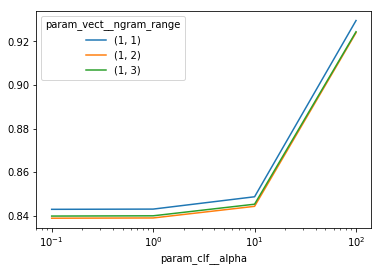

In [218]:
grouped=res_n.groupby(['param_vect__ngram_range','param_clf__alpha']).mean()
grouped.unstack('param_vect__ngram_range').plot(y='mean_train_score',logx=True)
grouped['mean_test_score']

param_vect__stop_words  param_vect__ngram_range  param_clf__alpha  param_vect__max_features
None                    (1, 1)                   0.1               1000                        0.916334
                                                                   2000                        0.837137
                                                                   3000                        0.811041
                                                 1.0               1000                        0.916213
                                                                   2000                        0.836677
                                                                   3000                        0.809955
                                                 10.0              1000                        0.916694
                                                                   2000                        0.838830
                                                                   3000     

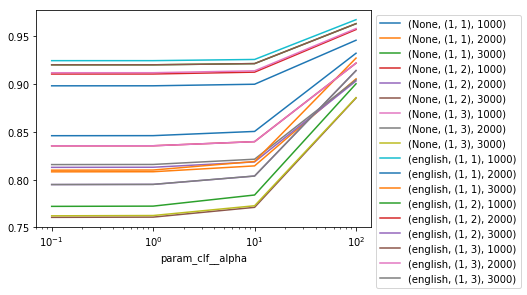

In [233]:
grouped=res_n.groupby(['param_vect__stop_words','param_vect__ngram_range','param_clf__alpha','param_vect__max_features']).mean()
ax=grouped.unstack('param_vect__stop_words').unstack('param_vect__ngram_range').unstack('param_vect__max_features').plot(y='mean_train_score',logx=True)
ax.legend(loc="upper left", bbox_to_anchor=(1,1))
grouped['mean_test_score']